<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 3: Practical - PyTorch Classification <br>
<font color=696880 size=4>
    Javad Hezareh 
    
    
____


### Full Name : Sayeh Jarollahi
### Student Number : 98101339
___

# Problem
This assignment uses PyTorch to build and implement a MLP model for solving a classification problem. Our goal is to classify galaxy images into 4 classes: ellipticals, lenticulars, spirals, and irregulars. We will use [EFIGI](https://www.astromatic.net/projects/efigi/) dataset which contains 4458 images.

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
import cv2
! pip install torchmetrics
from torchmetrics.classification import ConfusionMatrix
###########################################################
##  If you need any other packages, import them below    ##
###########################################################


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 28.4 MB/s 


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prepare and Visualize Data (10 Points)

Run the following cell to download dataset. `prepare_data` will return a pandas dataframe which contains three columns. `name` is the name of image that you can find that in `./efigi-1.6/png`, `class_name` is the type of galaxy in that image and `class_label` is a numerical label for this class.

In [9]:
# run this cell to download and prepare data
from data_utils import download_data, prepare_data

download_data()
df = prepare_data('./efigi-1.6/EFIGI_attributes.txt')

df.head()

efigi_png downloaded!
efigi_tables downloaded!


,name,class_name,class_label
0,PGC0000212,Spirals,2
1,PGC0000218,Spirals,2
2,PGC0000243,Lenticulars,1
3,PGC0000255,Spirals,2
4,PGC0000281,Spirals,2


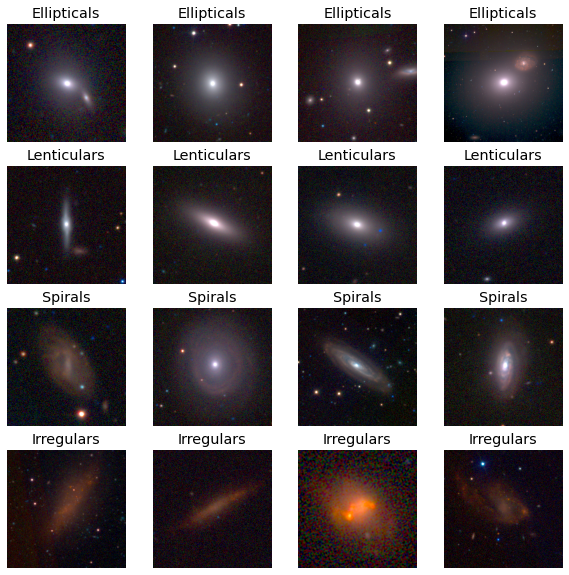

In [10]:
##############################################################
##            Visualize 4 sample from each class            ##
##                        Your Code                         ##
##############################################################
import cv2
fig = plt.figure(figsize=(10, 10))
image_count = 1
for lbl in range(4):
    data = df.loc[df['class_label']== lbl]
    class_name = data['class_name'].iloc[0]
    choices = np.random.choice(list(data['name']), size=4, replace=False)
    for choice in choices:
        fig.add_subplot(4, 4, image_count)
        image_count += 1
        image = cv2.imread(f'efigi-1.6/png/{choice}.png')
        plt.imshow(image)
        plt.axis('off')
        plt.title(class_name)




# Define Dataset (20 Points)

In [11]:
###############################################################
##        Write your dataset class for loading images        ##
##                        Your Code                          ##
###############################################################

class GalaxyDataSet(Dataset):
    def __init__(self, root_dir, df, transform = [transforms.ToTensor(), transforms.Grayscale(num_output_channels =1)]):
        self.root_dir = root_dir
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.df[idx][0]
        addr = self.root_dir + file_name + '.png'
        label = self.df[idx][2]
        img = cv2.imread(addr)
        for t in self.transform:
            img = t(img)
        return img, label
        

# Define Model (20 Points)

In [12]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################

class ClassifierModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(              
            nn.Flatten(),
            nn.Linear(255*255, 1024), 
            nn.Tanh(),
            nn.Linear(1024, 512), 
            nn.Tanh(),
            nn.Linear(512, 128), 
            nn.Tanh(),
            nn.Linear(128, 4), 
        )


    def forward(self, x):
        return self.mlp(x)
        return x

# Train Model (30 Points)

In [13]:
net = ClassifierModel().to(device)
loss = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

In [14]:
num_threads = 4     # Loading the dataset is using 4 CPU threads
batch_size  = 128   # Using minibatches of 128 samples

train_dataset, valid_dataset, test_dataset = torch.utils.data.dataset.random_split(df.values.tolist(), [0.7, 0.15, 0.15])
train_dataset = GalaxyDataSet('efigi-1.6/png/',train_dataset)
valid_dataset = GalaxyDataSet('efigi-1.6/png/', valid_dataset)
test_dataset  = GalaxyDataSet('efigi-1.6/png/', test_dataset )

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,                # <-- this reshuffles the data at every epoch
                                          num_workers=num_threads)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          num_workers=num_threads)


test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=num_threads)


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [15]:
def train(model, loader, f_loss, optimizer, device):
    model.train()
    for i, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = f_loss(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test(model, loader, f_loss, device):
    with torch.no_grad():
        model.eval()
        N = 0
        tot_loss, correct = 0.0, 0.0
        all_predicted , all_targets =torch.tensor([]).to(device), torch.tensor([]).to(device)
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            N += inputs.shape[0]
            tot_loss += inputs.shape[0] * f_loss(outputs, targets).item()
            predicted_targets = outputs.argmax(dim=1)
            predicted_targets.to(device)
            all_predicted.to(device)
            all_predicted = torch.cat((all_predicted, predicted_targets))
            all_targets = torch.cat((all_targets, targets))
            correct += (predicted_targets == targets).sum().item()
        confmat = ConfusionMatrix(task="multiclass", num_classes=4).to(device)
        print('confusion matrix: ',confmat(all_predicted, all_targets))

        return tot_loss/N, correct/N

def run_epochs():
    FC1 = []
    FC2 = []
    FC3 = []
    FC4 = []
    for t in range(20):
        print("Epoch {}".format(t))
        train(net, train_loader, loss, optimizer, device)
        val_loss, val_acc = test(net, valid_loader, loss, device)
        train_loss, train_acc = test(net, train_loader, loss, device)
        FC1.append(val_loss)
        FC2.append(val_acc)
        FC3.append(train_loss)
        FC4.append(train_acc)
        print(" Training : Loss : {:.4f}, Acc : {:.4f}".format(train_loss, train_acc))
        print(" Validation : Loss : {:.4f}, Acc : {:.4f}".format(val_loss, val_acc))

run_epochs()

Epoch 0
confusion matrix:  tensor([[  0,   0,  38,   0],
        [  0,   0,  80,   0],
        [  0,   0, 500,   0],
        [  0,   0,  51,   0]], device='cuda:0')
confusion matrix:  tensor([[   0,    0,  208,    0],
        [   0,    0,  371,    0],
        [   0,    0, 2317,    0],
        [   0,    0,  225,    0]], device='cuda:0')
 Training : Loss : 0.8275, Acc : 0.7424
 Validation : Loss : 0.8173, Acc : 0.7474
Epoch 1
confusion matrix:  tensor([[  0,   0,  38,   0],
        [  0,   0,  80,   0],
        [  0,   0, 500,   0],
        [  0,   0,  51,   0]], device='cuda:0')
confusion matrix:  tensor([[   0,    0,  208,    0],
        [   0,    0,  371,    0],
        [   0,    0, 2317,    0],
        [   0,    0,  225,    0]], device='cuda:0')
 Training : Loss : 0.7783, Acc : 0.7424
 Validation : Loss : 0.7797, Acc : 0.7474
Epoch 2
confusion matrix:  tensor([[  0,   0,  38,   0],
        [  0,   0,  80,   0],
        [  0,   0, 500,   0],
        [  0,   0,  51,   0]], device='cuda

# Test Model (20)

In [23]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################
def f1_score(confusion_matrix):
    """
    calculate macro f1 score from given confusion matrix

    Args:
        confusion_matrix : given confusion matrix
        
    Returns:
        f1 : macro f1 score
    """
    confusion_matrix = confusion_matrix.cpu().numpy()
    f1_score = 2 * confusion_matrix.diagonal() / (np.sum(confusion_matrix, axis=0) + np.sum(confusion_matrix, axis=1))
    f1_score = np.mean(f1_score)
    
    return f1_score

def test(model, loader, f_loss, device):
    with torch.no_grad():
        model.eval()
        N = 0
        tot_loss, correct = 0.0, 0.0
        all_predicted , all_targets =torch.tensor([]).to(device), torch.tensor([]).to(device)
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            N += inputs.shape[0]
            tot_loss += inputs.shape[0] * f_loss(outputs, targets).item()
            predicted_targets = outputs.argmax(dim=1)
            predicted_targets.to(device)
            all_predicted.to(device)
            all_predicted = torch.cat((all_predicted, predicted_targets))
            all_targets = torch.cat((all_targets, targets))
            correct += (predicted_targets == targets).sum().item()
        confmat = ConfusionMatrix(task="multiclass", num_classes=4).to(device)
        final_confmat = (confmat(all_predicted, all_targets))

        return tot_loss/N, correct/N, final_confmat
test_loss, test_acc, confmat = test(net, test_loader, loss, device)
print('Test loss is: ', test_loss)
print('Test Accuracy is:', test_acc)
print('Confusion matrix: ', confmat)
print('F1 score is:', f1_score(confmat))

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test loss is:  0.6250177496921516
Test Accuracy is: 0.7709580838323353
Confusion matrix:  tensor([[ 11,  29,   3,   0],
        [  4,  65,  17,   0],
        [  7,  53, 436,   2],
        [  1,   0,  37,   3]], device='cuda:0')
F1 score is: 0.4754068258915673
